In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [4]:
def portfolio_volatility(weights, cov_matrix):
    """
    Calculate the volatility of the portfolio given the weights and covariance matrix.
    """
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def portfolio_return(weights, expected_returns):
    """
    Calculate the return of the portfolio given the weights and expected returns.
    """
    return np.sum(weights * expected_returns)

def negative_portfolio_return(weights, expected_returns):
    """
    Negative function of portfolio return for minimization.
    """
    return -portfolio_return(weights, expected_returns)

def minimize_volatility(target_return, cov_matrix, expected_returns):
    """
    Minimize portfolio volatility for a target return.
    """
    num_assets = len(expected_returns)
    initial_weights = np.repeat(1/num_assets, num_assets) # Equal initial weights
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}, # Sum of weights equals 1
                   {'type': 'eq', 'fun': lambda weights: portfolio_return(weights, expected_returns) - target_return}) # Target return constraint
    bounds = tuple((0, 1) for asset in range(num_assets)) # Bounds for weights (0 <= weight <= 1)
    result = minimize(portfolio_volatility, initial_weights, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [12]:
# Define the symbols of the magnificent 8 stocks
symbols = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA']

# Fetch stock price data from Yahoo Finance for the last 3 years
start_date = pd.Timestamp.now() - pd.DateOffset(years=3)
end_date = pd.Timestamp.now()
stock_data = yf.download(symbols, start=start_date, end=end_date)['Adj Close']

# Drop any missing values
stock_data.dropna(inplace=True)

# Calculate daily returns
returns_df = stock_data.pct_change().dropna()

# Calculate covariance matrix
cov_matrix = returns_df.cov()

# Calculate expected returns
expected_returns = returns_df.mean()

# Define target returns for the p portfolio combinations
p = 100
target_returns = np.linspace(min(expected_returns), max(expected_returns), p)

[*********************100%%**********************]  8 of 8 completed


In [13]:
# Initialize lists to store results
volatility_list = []
return_list = []
portfolio_weights = []

# Loop through target returns and find the corresponding portfolios
for target_return in target_returns:
    result = minimize_volatility(target_return, cov_matrix, expected_returns)
    volatility = portfolio_volatility(result.x, cov_matrix)
    volatility_list.append(volatility)
    return_list.append(target_return)
    portfolio_weights.append(result.x)

# Create a DataFrame to store portfolio weights
portfolio_df = pd.DataFrame(portfolio_weights, columns=symbols)
portfolio_df.index.name = 'Portfolio'
portfolio_df.index += 1  # Shift index by 1 to start from Portfolio 1

# Print the DataFrame
print(portfolio_df)

                   AAPL          MSFT         GOOGL          AMZN  \
Portfolio                                                           
1          0.000000e+00  4.423545e-17  3.370472e-17  1.415286e-16   
2          3.191891e-16  2.637170e-01  0.000000e+00  0.000000e+00   
3          0.000000e+00  5.274339e-01  2.818926e-18  7.806256e-18   
4          3.032883e-02  7.007492e-01  0.000000e+00  0.000000e+00   
5          1.437156e-01  6.264918e-01  1.084202e-17  0.000000e+00   
...                 ...           ...           ...           ...   
96         3.166477e-21  0.000000e+00  0.000000e+00  3.989864e-17   
97         0.000000e+00  2.082740e-18  0.000000e+00  2.797242e-17   
98         3.551275e-20  0.000000e+00  5.040300e-18  0.000000e+00   
99         2.535839e-18  0.000000e+00  0.000000e+00  1.127570e-17   
100        0.000000e+00  3.330669e-16  0.000000e+00  5.415188e-09   

                   META          TSLA          NFLX          NVDA  
Portfolio                         

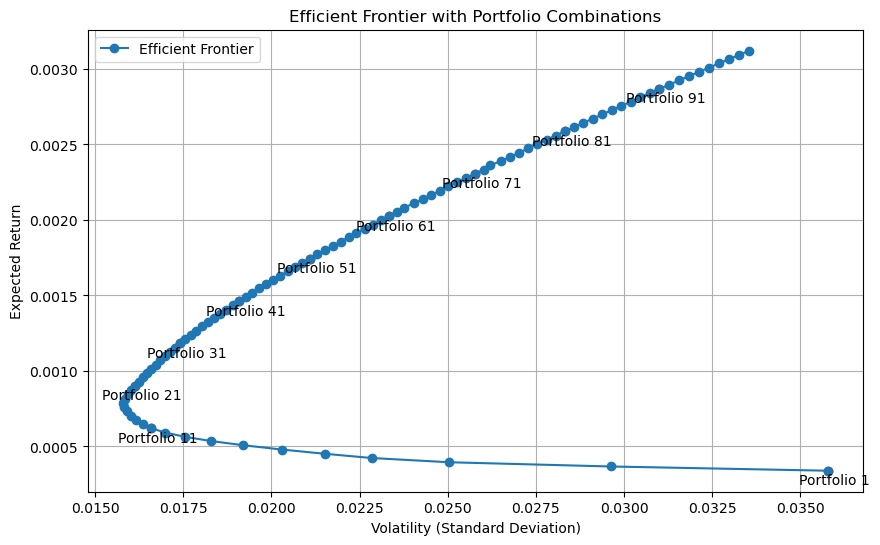

In [19]:
# Plot efficient frontier
plt.figure(figsize=(10, 6))
plt.plot(volatility_list, return_list, marker='o', linestyle='-', label='Efficient Frontier')

# Plot each portfolio combination with a note
for i, weights in enumerate(portfolio_weights):
    if i % 10 == 0:  # Check if the index is divisible by 5
        plt.scatter(volatility_list[i], return_list[i], color='red', label=None)
        plt.annotate(f"Portfolio {i+1}", (volatility_list[i], return_list[i]), textcoords="offset points", xytext=(5,-10), ha='center')

plt.title('Efficient Frontier with Portfolio Combinations')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True)
plt.show()